# Train smarter Naive Bayes model with labelled data

The running of this script creates new pickle object with Naive Bayes model. Periodically runs the notebook and replace the pickle file in object with a new one as it only gets better with more data.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.naive_bayes import ComplementNB
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline

In [2]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/vlado/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('long_articles.csv', header=None)
df.columns = ['index','date', 'text', 'naive_bayes_label', 'neural_net_label', 'checked_label']
df = df[['text', 'checked_label']]
df = df.dropna()
df.shape

(907, 2)

In [4]:
df2 = pd.read_csv('long_articles2.csv', header=None)
df2.columns = ['index', 'date', 'text', 'naive_bayes_label', 'neural_net_label', 'checked_label']
df2 = df2[['text', 'checked_label']]
df2 = df2.dropna()
df2.shape

(100, 2)

In [5]:
df = df.append(df2)
df

,text,checked_label
0,"Nothing, they are just drawing and shading qua...",AI/Data Science
1,In the last 1-2 years he has diverged greatly ...,AI/Data Science
2,I used extensively the theta mention in a fore...,AI/Data Science
3,"I wonder if it is possible that Deep Learning,...",AI/Data Science
4,"As a small physical-goods business, we&#x27;ve...",AI/Data Science
...,...,...
95,&gt; <i>And I&#x27;m saying that it&#x27;s wro...,finance
96,The article is trying to provide a framework f...,finance
97,My only issue with CSS is the absence of conta...,web/mobile
98,That example you mentioned would be just a cou...,web/mobile


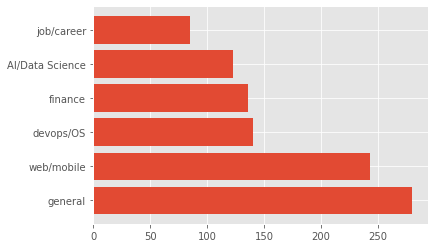

In [6]:
plt.figure(figsize=[6,4])
plt.barh(df['checked_label'].value_counts().index, df['checked_label'].value_counts());

We are going to have to clean the junk out of the text.

In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\d', '', text)
    text = text.strip(' ')
    return text

def remove_stopwords(row):
    final_row = [w for w in row.split(' ') if w not in stopwords.words('english')]
    final_row = ' '.join(final_row)
    return final_row


In [8]:
df['text'] = df['text'].map(clean_text)
df['text'] = df['text'].map(remove_stopwords)

In [9]:
df

,text,checked_label
0,nothing drawing shading quads practical gpu be...,AI/Data Science
1,last years diverged greatly ai stuff podcast...,AI/Data Science
2,used extensively theta mention forecasting cou...,AI/Data Science
3,wonder possible deep learning gpus bitcoin mat...,AI/Data Science
4,small physical goods business x run adwords ad...,AI/Data Science
...,...,...
95,gt x saying x wrong vocal higher taxes know hi...,finance
96,article trying provide framework wealthy peopl...,finance
97,issue css absence container queries need rely...,web/mobile
98,example mentioned would couple lines html css ...,web/mobile


## Tf-IDF

Here we use Tf IDf which is a method based mainly on the frequency of the words. It's very good with the simpler models that we will be creating  here. 

In [10]:
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(df['text'])

In [11]:
x_train = x_train.toarray()

In [12]:
df['checked_label'].unique()

array(['AI/Data Science', 'devops/OS', 'finance', 'general', 'job/career',
       'web/mobile'], dtype=object)

In [13]:
df['checked_label'] = df['checked_label'].map({'AI/Data Science': 0, 'devops/OS': 1, 'finance': 2, 
                                               'general': 3, 'job/career': 4,  'web/mobile': 5})
y_train = df['checked_label'] 

In [14]:
x_train.shape, y_train.shape

((1007, 10027), (1007,))

## Split into train - test 


In [15]:
# oversample = RandomOverSampler({0: 250, 1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 250})
# x_train, y_train = oversample.fit_resample(x_train, y_train)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

In [17]:
x_train.shape, y_train.shape

((704, 10027), (704,))

In [18]:
x_test.shape, y_test.shape

((303, 10027), (303,))

## Naive Bayes

Very good with text data, sparse matrices and tf-idf.

In [19]:
nb = ComplementNB()

In [20]:
nb.fit(x_train, y_train)

ComplementNB()

In [21]:
preds = nb.predict(x_test)

In [22]:
def print_metrics(model, predictions):
    print(f'Train Accuracy: {model.score(x_train, y_train)}')
    print(f'Test Accuracy: {model.score(x_test, y_test)}')
    print(f'F1 score: {f1_score(predictions, y_test, average = "weighted")}')

In [23]:
print_metrics(nb, preds)

Train Accuracy: 0.9928977272727273
Test Accuracy: 0.6633663366336634
F1 score: 0.6674652935899743


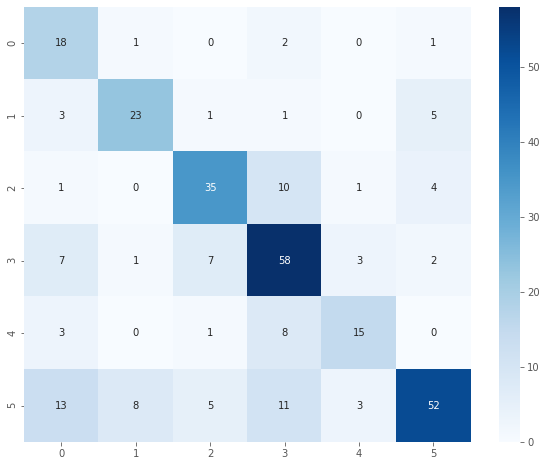

In [24]:
def show_confusion_matrix(predictions):
    conf_matrix = confusion_matrix(predictions, y_test)
    plt.figure(figsize=[10,8])
    sns.heatmap(conf_matrix, annot = True, fmt ='d',cmap = 'Blues');

show_confusion_matrix(preds)

## Save model

Let's create a pipeline that will ease the model when serves in production.

In [25]:
pipe = Pipeline([('vectorizer', TfidfVectorizer()), ('nb', ComplementNB())])
pipe.fit(df['text'] , df['checked_label'] )

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('nb', ComplementNB())])

In [26]:
def test_with_random_text(txt):
    txt = clean_text(txt)
    txt = remove_stopwords(txt)
    pred = pipe.predict([txt])
    return pred

In [27]:
pred = test_with_random_text('Windows is the worst OS there is. I hope people will soon see the excelence of Linux')
pred

array([1])

In [28]:
pred = test_with_random_text('This is all about politics.This is not in our labels so it should be general')
pred

array([3])

In [29]:
pred = test_with_random_text('AWS is the first cloud provider that i can think of. The label should be one')
pred

array([1])

In [30]:
import pickle
save_classifier = open("nb_topic_classifier.pickle","wb")
pickle.dump(pipe, save_classifier)
save_classifier.close()